Fetching data for multiple stocks...


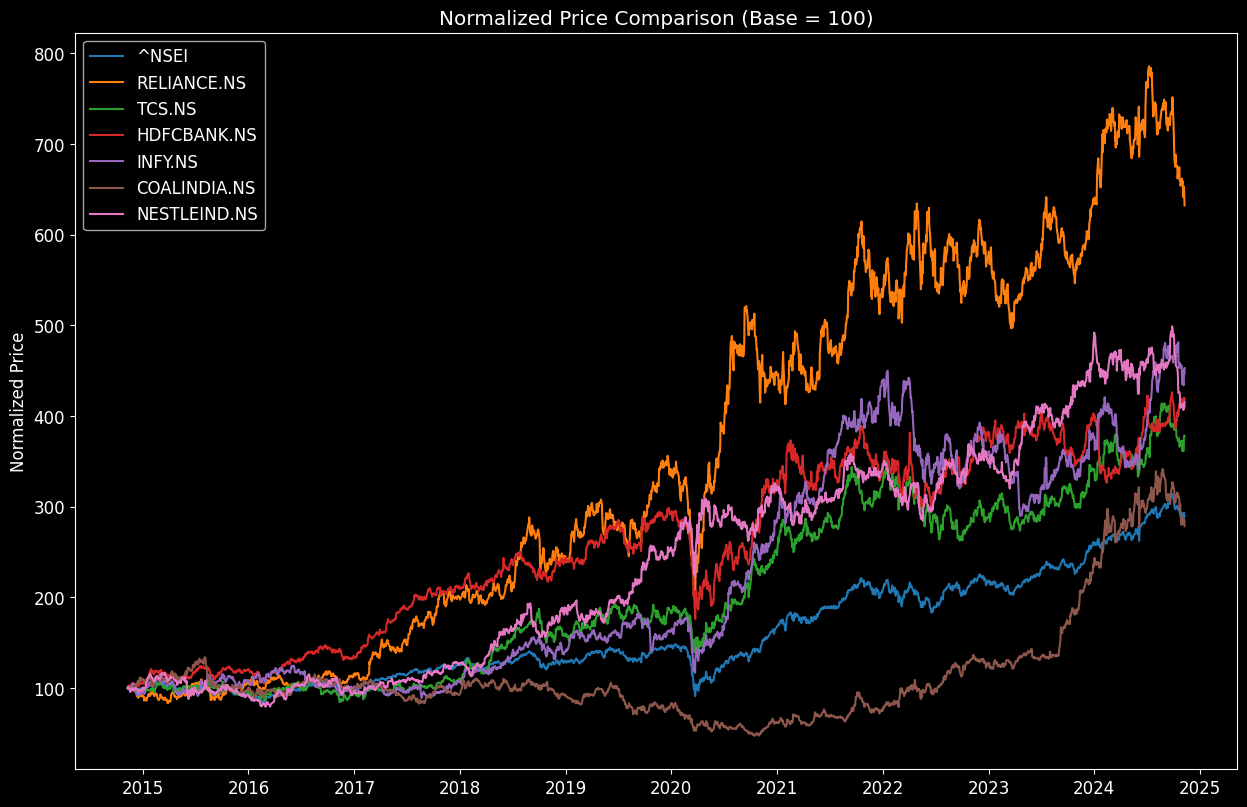

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

class NiftyStockChart:
    def __init__(self):
        plt.style.use('dark_background')
        sns.set_palette("husl")
        plt.rcParams['figure.figsize'] = (15, 10)
        plt.rcParams['font.size'] = 12
        
        # color palette for multiple stocks
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        
    def fetch_stock_data(self, symbols, period='10y'):
        """
        Fetch data for multiple stocks
        symbols: List of stock symbols
        period: Time period to fetch data for
        """
        try:
            data_frames = {}
            for symbol in symbols:
                stock = yf.Ticker(symbol)
                df = stock.history(period=period)
                # Normalize prices to 100 at start for fair comparison
                df['Normalized'] = (df['Close'] / df['Close'].iloc[0]) * 100
                data_frames[symbol] = df
            return data_frames
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def plot_comparison(self, data_frames, symbols):
        """Create comprehensive comparison plots"""
        fig = plt.figure(figsize=(15, 20))
        
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
        for i, symbol in enumerate(symbols):
            data = data_frames[symbol]
            ax1.plot(data.index, data['Normalized'], 
                    label=symbol, 
                    color=self.colors[i % len(self.colors)])
            
        ax1.set_title('Normalized Price Comparison (Base = 100)')
        ax1.set_ylabel('Normalized Price')
        ax1.legend(loc='upper left')
        return fig

    def compare_stocks(self, symbols):
        """Main function to compare multiple stocks"""
        data_frames = self.fetch_stock_data(symbols)
        if data_frames is None:
            return
        fig = self.plot_comparison(data_frames, symbols) 
        return data_frames, fig

def main():
    # Create analyzer instance
    analyzer = NiftyStockChart()
    
    # Define symbols to compare
    symbols = [
        '^NSEI',          # NIFTY 50
        'RELIANCE.NS',    # Reliance Industries
        'TCS.NS',         # Tata Consultancy Services
        'HDFCBANK.NS',    # HDFC Bank
        'INFY.NS',        # Infosys
        'COALINDIA.NS',   #CoalIndia
        'NESTLEIND.NS'    #NestleIndia
    ]
    
    print("Fetching data for multiple stocks...")
    data_frames, fig = analyzer.compare_stocks(symbols)
    plt.show()
    
if __name__ == "__main__":
    main()

In [2]:
from ipywidgets import widgets
from IPython.display import display, clear_output

checkbox_options = {
    'TCS': 'TCS.NS',
    'HDFC': 'HDFCBANK.NS', 
    'RELIANCE': 'RELIANCE.NS',
    'COALINDIA': 'COALINDIA.NS'
}

checkboxes = [widgets.Checkbox(
    value=False,
    description=key,
    disabled=False,
    indent=False
) for key in checkbox_options]

output = widgets.Output()

selected_values = []

def on_checkbox_change(change):
    analyzer = NiftyStockChart()
    checkbox = change['owner']
    value = checkbox_options[checkbox.description]
    
    output.clear_output()
    with output:
        if checkbox.value:  # If checkbox is checked
            if value not in selected_values:
                selected_values.append(value)
        else:  # If checkbox is unchecked
            if value in selected_values:
                selected_values.remove(value)
        if(len(selected_values) != 0):
            data_frames, fig = analyzer.compare_stocks(selected_values)
            plt.show()

for cb in checkboxes:
    cb.observe(on_checkbox_change, names='value')

vbox = widgets.VBox(checkboxes + [output])

display(vbox)

In [6]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import display
import ipywidgets as widgets

class StockTracker:
    def __init__(self):
        self.buy_points = []
        self.setup_widgets()
        
    def setup_widgets(self):
        # Stock symbol input
        self.symbol_input = widgets.Text(
            value='RELIANCE.NS',
            description='Stock Symbol:',
            style={'description_width': 'initial'}
        )
        
        # Date range selector
        self.date_range = widgets.Dropdown(
            options=['1mo', '3mo', '6mo', '1y', '2y', '5y'],
            value='1y',
            description='Time Period:',
            style={'description_width': 'initial'}
        )
        
        # Buy point inputs
        self.buy_date_input = widgets.DatePicker(
            description='Buy Date:',
            style={'description_width': 'initial'}
        )
        self.buy_quantity_input = widgets.IntText(
            value=1,
            description='Quantity:',
            style={'description_width': 'initial'}
        )
        self.buy_amount_input = widgets.FloatText(
            value=100.0,
            description='Amount (₹):',
            style={'description_width': 'initial'}
        )
        
        # Add buy point button
        self.add_buy_button = widgets.Button(
            description='Add Buy Point',
            button_style='success'
        )
        self.add_buy_button.on_click(self.add_buy_point)
        
        # Clear points button
        self.clear_button = widgets.Button(
            description='Clear Buy Points',
            button_style='warning'
        )
        self.clear_button.on_click(self.clear_buy_points)
        
        # Update graph button
        self.update_button = widgets.Button(
            description='Update Graph',
            button_style='info'
        )
        self.update_button.on_click(self.update_graph)
        
        # Output widget for the graph
        self.output = widgets.Output()
        
        # Layout
        self.input_widgets = widgets.VBox([
            widgets.HBox([self.symbol_input, self.date_range]),
            widgets.HBox([self.buy_date_input, self.buy_quantity_input, self.buy_amount_input]),
            widgets.HBox([self.add_buy_button, self.clear_button, self.update_button]),
            self.output
        ])
        
    def add_buy_point(self, b):
        if self.buy_date_input.value is not None:
            buy_point = {
                'date': self.buy_date_input.value,
                'quantity': self.buy_quantity_input.value,
                'amount': self.buy_amount_input.value
            }
            self.buy_points.append(buy_point)
            self.update_graph(None)
            
    def clear_buy_points(self, b):
        self.buy_points = []
        self.update_graph(None)
    
    def update_graph(self, b):
        self.output.clear_output()
        with self.output:
            try:
                # Add .NS suffix if not present
                symbol = self.symbol_input.value
                if not symbol.endswith('.NS') and not symbol.endswith('.BO'):
                    symbol = f"{symbol}.NS"
                
                # Fetch stock data
                stock = yf.Ticker(symbol)
                df = stock.history(period=self.date_range.value)
                
                # Create the candlestick chart with dark theme colors
                fig = go.Figure(data=[go.Candlestick(
                    x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'],
                    increasing_line_color='#26A69A',  # Green color for upward movement
                    decreasing_line_color='#EF5350'   # Red color for downward movement
                )])
                
                # Add buy points
                buy_dates = []
                buy_prices = []
                buy_texts = []
                
                for point in self.buy_points:
                    date = point['date']
                    if date in df.index:
                        buy_dates.append(date)
                        buy_prices.append(df.loc[date]['Close'])
                        buy_texts.append(f"Buy: {point['quantity']} shares<br>Amount: ₹{point['amount']:,.2f}")
                
                if buy_dates:
                    fig.add_trace(go.Scatter(
                        x=buy_dates,
                        y=buy_prices,
                        mode='markers+text',
                        name='Buy Points',
                        marker=dict(
                            color='#00E676',  # Bright green for visibility
                            size=15,
                            symbol='triangle-up'
                        ),
                        text=buy_texts,
                        textposition="top center",
                        textfont=dict(
                            color='#FFFFFF'  # White text
                        )
                    ))
                
                # Update layout with dark theme
                fig.update_layout(
                    template='plotly_dark',  # Use dark template
                    paper_bgcolor='#1e1e1e',  # Dark background
                    plot_bgcolor='#1e1e1e',   # Dark plot area
                    title=dict(
                        text=f'{symbol} Stock Price',
                        font=dict(color='#FFFFFF')  # White title
                    ),
                    yaxis=dict(
                        title='Price (₹)',
                        gridcolor='#3d3d3d',  # Darker grid lines
                        tickfont=dict(color='#FFFFFF')  # White tick labels
                    ),
                    xaxis=dict(
                        title='Date',
                        gridcolor='#3d3d3d',  # Darker grid lines
                        tickfont=dict(color='#FFFFFF')  # White tick labels
                    ),
                    height=600,
                    showlegend=True,
                    legend=dict(
                        font=dict(color='#FFFFFF')  # White legend text
                    )
                )
                
                # Update grid and zero lines
                fig.update_xaxes(showgrid=True, zeroline=True, zerolinecolor='#3d3d3d')
                fig.update_yaxes(showgrid=True, zeroline=True, zerolinecolor='#3d3d3d')
                
                fig.show()
                
            except Exception as e:
                print(f"Error: {str(e)}")
                print("Please check the stock symbol and try again.")
    
    def display(self):
        display(self.input_widgets)

# Create and display the tracker
tracker = StockTracker()
tracker.display()